In [86]:
# -- Import Packages -- #
import numpy as np
import astropy.constants as c
import astropy.units as u
import matplotlib.pyplot as plt
import sys
import argparse

from grey_model import GreyModel
model = GreyModel()

model.apply_opacs()

kappa_ross = model.kappa_ross
kappa_v = model.kappa_visual

gamma_v = kappa_v/kappa_ross

R = np.arange(0.05, 10, 0.05)
tau = np.logspace(-6, 6, 50)



In [87]:
np.shape(gamma_v[0,:])

(50,)

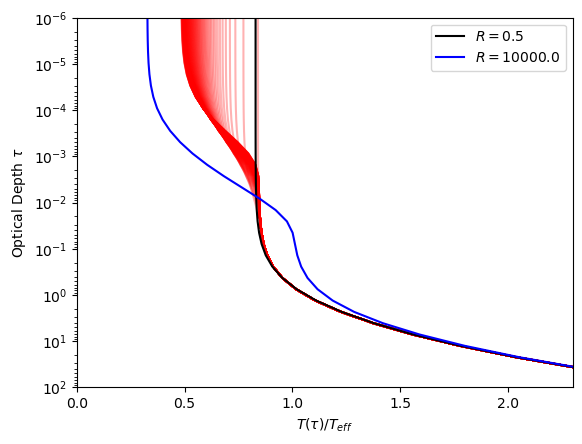

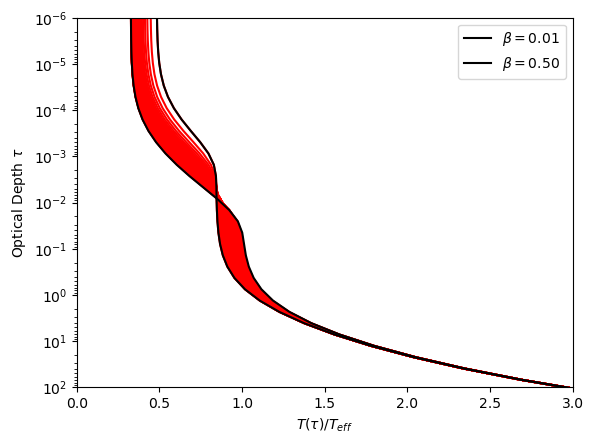

In [103]:
"""
Non-Grey Atmospheric Model
Based on the work of Parmentier & Guillot (2014)

Model will produce a temperature-optical depth profile for a given set of arguments,
arguments can be changed to see how the temperature profile changes.

# -- For Vernica -- #
To get temperature - optical depth relation, the following will give this to you

------------------------------------
from non_grey import nonGreyModel
T_nonGrey = nonGreyModel()
------------------------------------

Optical depth is assumed to be of form:

tau = np.logspace(-6, 6, 50)

You can adjust any of the parameters by running the code above with kwargs, defaults are
set to the values we decided for the semi-grey model. If you wish to change any of the
values, you can use the following:

------------------------------------
from non_grey import nonGreyModel

kwargs = {
    "T_eff": ,
    "T_eff_sun": ,
    "R_star": ,
    "d": ,
    "mu": ,
    "gamma_v": ,
    "modelParamChange": ,
    "R": ,
    "beta": ,
    "tau_lim": ,
    "gamma_P": 
    }

T_nonGrey = nonGreyModel(**kwargs)
------------------------------------

Default values will kick in for any values not used, just make sure to remove them from kwargs,
more details on what each kwargs does is listed in the -help line for the function. 

If you run this file, some plots will be produced for a series of different R and beta values to show
how it affects the temperature profile

"""

# Import visible opacities from grey_model.py by Vernica to use in non-grey model




# -- Call Arguments -- #





def nonGreyModel(**kwargs):
    """
    Function for non-grey atmospheric model.
    Based on the work of Parmentier & Guillot (2014)
    Keyword arguments have default values, but can be changed if you want by defining them before calling the function.
    Additionally, there are args for the script that can be set when running the script from the command line



    kwargs
    -----------
    T_eff: float
        Effective temperature of planet in Kelvin.
        default is 144K (Jupiter-like)
    T_eff_sun : float
        Effective temperature of sun in Kelvin.
        default is 6500K (solar irradiation)
    kappa_v : array
        Visible opacity in cm^2/g

    mu : float
        Cosine of angle of incidence of incomming radiation
        Values of between 0 to 1
    R_star : float
        Radius of irradiating star
        default is 1 solar radius
    d : float
        Distance of irradiating star to exoplanet
        default is 5.2 AU (Jupiter distance to sun)



  
    modelParamChange : bool
        if True: Changing thermal opacities, variables become R and beta
        if False: Changing overall profile, variables become kappa_P and tau_lim
    
    R : array
        Ratio of Thermal line and continuum opacities kappa_1/kappa_2
        Only used if modelParamChange is True
    beta : array
        Partitioning of thermal opacity between two channels
        Only used if modelParamChange is True

        
    tau_lim : float
        Optical depth limit for picket fence model
        Only used if modelParamChange is False
    gamma_P : float
        Ratio of Planck mean thermal opacity to Roeseland mean visible opacity kappa_P/kappa_R
        Only used if modelParamChange is False

    
    """
    # ----------------------------------------------------------------


    # -- Coeffients -- #
    # Calculate temperature profile coefficients
    mu = kwargs.get('mu', 1) # angle of inicidence of incoming radiation


    T_eff_sun = kwargs.get('T_eff_sun', 6500*u.K) # Irradiation temperature in Kelvin

    T_eff = kwargs.get('T_eff', 144*u.K)

    W = (kwargs.get('R_star', c.R_sun)/kwargs.get('D', 5.2*u.AU))**2 * mu**2

    T_irr = W * T_eff_sun

    T_int = (T_eff**4 - T_irr**4)**(1/4)

    # Call Visible opacities from arguments
    gamma_v = kwargs.get('gamma_v') # Visible opacity

   
    tau = np.logspace(-6, 6, 50) # Optical depth array
    
    

    # Based on which paramters are being changed for the model, define the other parameters accordingly
    if kwargs.get('modelParamChange', True) == True:
    
        # Get parameters from kwargs or set defaults
        
        beta = kwargs.get('beta', 0.5)
        R = kwargs.get('R', 0.1)

        gamma_P = beta + R - beta*R + (beta + R - beta*R)/R - (beta + R - beta*R)**2/R
        tau_lim = (np.sqrt(R)*np.sqrt(beta*(R-1)**2 - beta**2 *(R - 1)**2 + R))/(np.sqrt(3)*(beta + R - beta*R)**2)
    
    else:
        # Get parameters from kwargs or set defaults
        gamma_P = kwargs.get('gamma_P', 0.4)
        tau_lim = kwargs.get('tau_lim', 100)

        # Calculate other params for model
        delta = 3*gamma_P + 3*np.sqrt(gamma_P) * tau_lim*(2*np.sqrt(3)*gamma_P + 3*gamma_P**(3/2)*tau_lim - 4*np.sqrt(3))

        R = (np.sqrt(3*gamma_P) + 3*gamma_P*tau_lim + np.sqrt(delta)) / (np.sqrt(3*gamma_P) +3*gamma_P*tau_lim - np.sqrt(delta))
        beta = (np.sqrt(delta) - np.sqrt(3*gamma_P) + 3*gamma_P*tau_lim)/(2*np.sqrt(delta))
    
    # Calculate gamma_1 and gamma_2
    gamma_1 = beta + R - beta*R
    gamma_2 = (beta + R - beta*R)/R

    

        

    # Calculate sub-coefficients for temperature profile coefficients (from page 8 and pretty ugly, sorry)
    A_t_1 = gamma_1**2 * np.log(1 + 1/(tau_lim*gamma_1))
    A_t_2 = gamma_2**2 * np.log(1 + 1/(tau_lim*gamma_2))
    
    a_0 = 1/(gamma_1) + 1/(gamma_2)

    #print(tau_lim, gamma_P)

    a_1 = -1/(3*tau_lim**2) * ( (gamma_P)/(1-gamma_P) * (gamma_1 + gamma_2 - 2)/(gamma_1 + gamma_2) +
             (gamma_1 + gamma_2)*tau_lim - (A_t_1 + A_t_2)*tau_lim**2)
    
    b_0 = ((gamma_1*gamma_2)/(gamma_1 - gamma_2) * (A_t_1 - A_t_2)/3 - (gamma_1*gamma_2)**2/np.sqrt(3*gamma_P) 
            - (gamma_1*gamma_2)**3/((1-gamma_1) * (1-gamma_2) * (gamma_1 + gamma_2))   )**-1
    
    A = 1/3 * (a_0 + a_1*b_0)

    B = -1/3 * (gamma_1*gamma_2)**2*b_0/gamma_P


    T_visible = 0


    for i in range(0,len(gamma_v)):
    
        A_v_1 = gamma_1**2 * np.log(1 + gamma_v[i]/gamma_1)
        A_v_2 = gamma_2**2 * np.log(1 + gamma_v[i]/gamma_2)

        a_2 = tau_lim**2/(gamma_P*gamma_v[i]**2) * ( (3*gamma_1**2 - gamma_v[i]**2) * (gamma_1 + gamma_2) -
            3*gamma_v[i]*(6*gamma_1**2*gamma_2**2 - gamma_v[i]**2*(gamma_1**2 + gamma_2**2)))/(1 - gamma_v[i]**2*tau_lim)

        a_3 = -(tau_lim**2 * (3*gamma_1**2 - gamma_v[i]**2) * (A_v_2 + A_v_1))/(gamma_P*gamma_v[i]**3 * (1 - gamma_v[i]**2*tau_lim**2))
        

        b_1 = gamma_1*gamma_2*(3*gamma_1**2 - gamma_v[i]**2)*(3*gamma_2**2
            - gamma_v[i]**2)*tau_lim/(gamma_P*gamma_v[i]**2*(gamma_v[i]**2*tau_lim**2 - 1))

        b_2 = 3*(gamma_1 + gamma_2)*gamma_v[i]**3/(gamma_P*gamma_v[i]**2*(gamma_v[i]**2*tau_lim**2 -1))

        b_3 = (A_v_2 - A_v_1)/(gamma_v[i]*(gamma_1 - gamma_2))
    

        
    
        C = -1/3 * (b_0*b_1*(1 + b_2 + b_3)*a_1 + a_2 + a_3)

        D = 1/3 * (gamma_1*gamma_2)**2/gamma_P * b_0*b_1*(1 + b_2 + b_3)

        E = (3 - (gamma_v[i]/gamma_1)**2)*(3 - (gamma_v[i]/gamma_2)**2)/(9*gamma_v[i]*((gamma_v[i]*tau_lim)**2 - 1))

        T_visible += 3*T_irr**4* mu/4*(C + D*np.exp(-tau/tau_lim) + E*np.exp(-gamma_v[i]*tau))
    
    T_all_opacities = 3*T_int**4/4 * (tau + A + B*np.exp(-tau/tau_lim)) + T_visible



    

    # -- Temperature Profile -- #
    # Define optical depth array
    

    # Define temperature profile
    # NOTE: the irradiated part can be expanded for more optical opacities, sum that part for each gamma_v

    T = (T_all_opacities)**(1/4)

    return T




if __name__ == "__main__":

    # Modify this if you want to play with the resultant temp profile for different R

    from grey_model import GreyModel
    model = GreyModel()

    model.apply_opacs()

    kappa_ross = model.kappa_ross
    kappa_v = model.kappa_visual

    gamma_v = kappa_v/kappa_ross

    R = np.arange(0.05, 10, 0.05)
    tau = np.logspace(-6, 6, 50)

    R = np.arange(0.5, 1e4, 100)
    for i in R:
        if i == 1:
            continue
        kwargs = {
        "T_eff": 1500*u.K,
        "T_eff_sun": 6500*u.K,
        "mu": 1/np.sqrt(3),
        "gamma_v": [10],
        "modelParamChange": True,
        "R": i,
        "beta": 0.01,
        "tau_lim": None,
        "gamma_P": None,
        "d": 5.2*u.AU,
        "R_star": c.R_sun
        }

        Temp_profile = nonGreyModel(**kwargs)/kwargs['T_eff']/u.K
        plt.plot(Temp_profile, tau, '-r', alpha = 0.3)
    

    R = [0.5]
    for i in R:
        if i == 1:
            continue
        kwargs = {
        "T_eff": 1500*u.K,
        "T_eff_sun": 6500*u.K,
        "mu": 1/np.sqrt(3),
        "gamma_v": [10],
        "modelParamChange": True,
        "R": i,
        "beta": 0.5,
        "tau_lim": None,
        "gamma_P": None,
        "d": 5.2*u.AU,
        "R_star": c.R_sun
        }

        Temp_profile = nonGreyModel(**kwargs)/kwargs['T_eff']/u.K
        plt.plot(Temp_profile, tau, '-k', label = '$R = {:.1f}$'.format(i))

    R = [1e4]
    for i in R:
        if i == 1:
            continue
        kwargs = {
        "T_eff": 1500*u.K,
        "T_eff_sun": 6500*u.K,
        "mu": 1/np.sqrt(3),
        "gamma_v": [10],
        "modelParamChange": True,
        "R": i,
        "beta": 0.5,
        "tau_lim": None,
        "gamma_P": None,
        "d": 5.2*u.AU,
        "R_star": c.R_sun
        }

        Temp_profile = nonGreyModel(**kwargs)/kwargs['T_eff']/u.K
        plt.plot(Temp_profile, tau, '-b', label = '$R = {:.1f}$'.format(i))
    
    
    plt.ylabel("Optical Depth $\\tau$")
    plt.xlabel("$T(\\tau)/T_{eff}$")
    plt.yscale('log')
    plt.ylim(1e-6, 1e2)
    plt.legend()
    plt.xlim(0,2.3)
    plt.gca().invert_yaxis()
    plt.show()


    beta = np.arange(0.01, 0.5, 0.01)
    for i in beta:
        if i == 1:
            continue
        kwargs = {
        "T_eff": 1500*u.K,
        "T_eff_sun": 6500*u.K,
        "mu": 1/np.sqrt(3),
        "gamma_v": [0.25],
        "modelParamChange": True,
        "R": 1e4,
        "beta": i,
        "tau_lim": None,
        "gamma_P": None,
        "d": 5.2*u.AU,
        "R_star": c.R_sun
        }

        Temp_profile = nonGreyModel(**kwargs)/kwargs['T_eff']/u.K

        plt.plot(Temp_profile, tau, '-r')
    
    beta = [0.01, 0.5]
    for i in beta:
        if i == 1:
            continue
        kwargs = {
        "T_eff": 144*u.K,
        "T_eff_sun": 6500*u.K,
        "mu": 1/np.sqrt(3),
        "gamma_v": [10],
        "modelParamChange": True,
        "R": 1e4,
        "beta": i,
        "tau_lim": None,
        "gamma_P": None,
        "d": 5.2*u.AU,
        "R_star": c.R_sun
        }

        Temp_profile = nonGreyModel(**kwargs)/kwargs['T_eff']/u.K

        plt.plot(Temp_profile, tau, '-k', label = '$\\beta = {:.2f}$'.format(i))

    plt.ylabel("Optical Depth $\\tau$")
    plt.xlabel("$T(\\tau)/T_{eff}$")
    plt.yscale('log')
    plt.legend()
    plt.ylim(1e-6, 1e2)
    plt.xlim(0,3)
    plt.gca().invert_yaxis()
    plt.show()
    
    